In [1]:
# Adapted from Robert Guthrie https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
# And: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import sklearn
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import json
import glob
import h5py
import time

np.random.seed(55)
torch.manual_seed(25)

In [2]:
if torch.cuda.is_available():  
    dev = 'cuda'
else:  
    dev = 'cpu'

device = torch.device(dev)  

In [3]:
all_cols = ['precip', 'temp', 'vpd', 'acres', 'winddevyr', 'meanwetfrq', 'cluster',
       'healthy', 'farmed', 'hydromod', 'fttoroad', 'sthick2013', 'mean_inun', 'lcf13',
       'lcf11', 'lcf14', 'lcf15', 'lcf2', 'lcf7', 'lcf6', 'lcf1', 'lcf12',
       'lcf9', 'lcf16', 'lcf8', 'lcf10', 'lcf3']

# Set Params

In [4]:
# Column selection
select_cols = ['precip', 'temp', 'vpd', 'acres',
                'cluster','farmed', 'hydromod',
               'healthy','fttoroad', 'sthick2013', 'mean_inun', #'winddevyr', 'meanwetfrq',  
               'lcf13','lcf11', 'lcf14', 'lcf15', 'lcf2', 'lcf7', 'lcf6', 'lcf1', 
               'lcf12', 'lcf9', 'lcf16', 'lcf8', 'lcf10', 'lcf3']
which_cols_from_hdf = np.isin(all_cols, select_cols)

# Output model dict path:
model_path = './model_weights.pytorch'

In [5]:
# IMPORTANT: Special flag if you want to run training with train + val, making test the val set
final_train_w_val = False
final_epochs = 37 # Original ran for 51 epochs, early stopping is 16 so best performance at 37

In [7]:
# Set the number of playas for modelling
num_playas = None # None means all playas will be used

# Model params to set
binary_cutoff = 0.25 # Predictions treated as 1 if larger than this fraction
hidden_dim = 128
id_embed_dim = 16
huc_embed_dim = 8
author_embed_dim = 4
num_layers=1
learning_rate = 0.001
num_epochs = 200
lr_gamma = 0.1
lr_decay_step_size = 6
lr_decay_stop_epoch = 30
regularization_weight = 3.75e-6
batch_size = 64
early_stopping=16 

# Input hdf file, have it set to direct mounted ssd on AWS EC2 but can be changed
hdf_path = '../data/all_prepped_data.h5'

# These are hard coded, the torch embedding layers need to know the max value they can expect
max_id = 71852
max_author = 4
max_huc = 140
lstm_input_size = len(select_cols)

# Set Up Dataloader

In [8]:
f = h5py.File(hdf_path, 'r')

# Get some params for reshaping
n_playas, train_seq_len = f['train_num'].shape[:2]
val_seq_len = f['val_num'].shape[1]
test_seq_len = f['test_num'].shape[1]

# Load data and run scaler simultaneously, requires some reshaping to 2d and back to 3d
scaler = StandardScaler()
train_num = scaler.fit_transform(
    f['train_num'][()][:,:,which_cols_from_hdf].reshape(
        [n_playas*train_seq_len, lstm_input_size])
    ).reshape([n_playas, train_seq_len, lstm_input_size])
train_cat = f['train_cat'][()].astype(int)
train_y = f['train_y'][()]
val_num = scaler.transform(
    f['val_num'][()][:,:,which_cols_from_hdf].reshape(
        [n_playas*val_seq_len, lstm_input_size])
    ).reshape([n_playas, val_seq_len, lstm_input_size])
val_cat = f['val_cat'][()].astype(int)
val_y = f['val_y'][()]
test_num = scaler.transform(
    f['test_num'][()][:,:,which_cols_from_hdf].reshape(
        [n_playas*test_seq_len, lstm_input_size])
    ).reshape([n_playas, test_seq_len, lstm_input_size])
test_cat = f['test_cat'][()].astype(int)
test_y = f['test_y'][()]

In [9]:
train_val_test_ds = torch.utils.data.TensorDataset(
    torch.Tensor(train_num), torch.Tensor(train_cat).long(), torch.Tensor(train_y),
    torch.Tensor(val_num), torch.Tensor(val_cat).long(), torch.Tensor(val_y),
    torch.Tensor(test_num), torch.Tensor(test_cat).long(), torch.Tensor(test_y)
    )
train_val_test_loader = torch.utils.data.DataLoader(
    train_val_test_ds,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False)

# Prep Model

In [10]:
# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self,
                 input_dim, hidden_dim, num_layers, output_dim,
                 id_embed_dim, max_id, huc_embed_dim, max_huc, author_embed_dim, max_author,
                 device):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.id_embed_dim = id_embed_dim
        self.max_id = max_id
        self.huc_embed_dim = huc_embed_dim
        self.max_huc = max_huc
        self.author_embed_dim = author_embed_dim
        self.max_author = max_author
        
        self.full_input_dim = self.input_dim + self.id_embed_dim + self.huc_embed_dim + self.author_embed_dim
        
        self.device = device
        
        # Define embedding layers
        self.id_embedding = nn.Embedding(self.max_id+1, self.id_embed_dim).to(self.device)
        self.huc_embedding = nn.Embedding(self.max_huc+1, self.huc_embed_dim).to(self.device)
        self.author_embedding = nn.Embedding(self.max_author+1, self.author_embed_dim).to(self.device)

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.full_input_dim, self.hidden_dim, self.num_layers, batch_first=True).to(self.device)

        # Define activations for output
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        

    def init_hidden(self, batch_size):
        self.h = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
        self.c = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
        return

    
    def forward(self, input_numeric, playa_ids, hucs, auths):
        # Forward pass through LSTM layer
        # shape of input: [batch_size, timesteps, input_dims]
        # shape of lstm_out: [batch_size, timesteps, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        # Shape of y_pred: [batch_size, timesteps, 4]
        # Run ids through embedding layer        
        # Concat and run through LSTM
        
        
        # Check that hidden layers have expected shape
        assert self.h.shape == torch.Size([self.num_layers, input_numeric.size(0), self.hidden_dim])
        assert self.c.shape == torch.Size([self.num_layers, input_numeric.size(0), self.hidden_dim])

        # Run categorical data through embeddings
        self.id_emb= self.id_embedding(playa_ids.to(self.device))
        self.huc_emb= self.huc_embedding(hucs.to(self.device))
        self.author_emb= self.author_embedding(auths.to(self.device))


        # Concat embedding and inputs and run through LSTM
        lstm_out, (self.h, self.c) = self.lstm(
            torch.cat((input_numeric, self.id_emb, self.huc_emb, self.author_emb), 2),
            (self.h, self.c)
        )
        
        # Assert that shapes are still as expected
        assert self.h.shape == torch.Size([self.num_layers, input_numeric.size(0), self.hidden_dim])
        assert self.c.shape == torch.Size([self.num_layers, input_numeric.size(0), self.hidden_dim])
        assert lstm_out.shape == torch.Size([input_numeric.size(0), input_numeric.size(1), self.hidden_dim]) # batch, seq_len, hidden

        
        # Run activation and get outputs
        lin_act = self.linear(lstm_out)
        y_pred = self.sigmoid(lin_act) 

        # Check that outputs are expected shape [batch_size, seq_len, 1]
        assert lin_act.shape == torch.Size([input_numeric.size(0), input_numeric.size(1), 1])
        assert lin_act.shape == y_pred.shape

        return y_pred


model = LSTM(input_dim = lstm_input_size,
             hidden_dim=hidden_dim,
             num_layers=num_layers,
             output_dim=1,
             id_embed_dim = id_embed_dim,
             max_id = max_id,
             huc_embed_dim = huc_embed_dim,
             max_huc = max_huc,
             author_embed_dim = author_embed_dim,
             max_author = max_author,
             device=device)

if dev == 'cuda':
    model.cuda()

In [11]:
bceloss = torch.nn.BCELoss()   
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_weight)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=lr_decay_step_size, gamma=lr_gamma)


if final_train_w_val:
    use_early_stopping = False
    num_epochs = final_epochs
else:
    use_early_stopping = True
    
#####################---------------------------------------------------------------------------
# Train model
#####################

loss_history = []
val_loss_history = []

best_loss = 1000
i=0
for t in range(num_epochs):
    epoch_loss = 0
    val_epoch_loss = 0
    total_items = 0
    val_total_items = 0
    # Lists to store all predictions and all ordered groundtruth
    cur_train_y_ordered = []
    cur_val_y_ordered = []
    all_train_pred = []
    all_val_pred = []
    for (x_batch, cat_batch, y_batch,
         val_x_batch, val_cat_batch, val_y_batch,
         test_x_batch, test_cat_batch, test_y_batch) in train_val_test_loader:
        if final_train_w_val:
            # Concatenate train and val, assign test to "val":
            x_batch = torch.cat([x_batch, val_x_batch], 1).to(device)
            cat_batch = torch.cat([cat_batch, val_cat_batch], 1).to(device)
            y_batch = torch.cat([y_batch, val_y_batch],1).to(device)
            val_x_batch = test_x_batch.to(device)
            val_cat_batch = test_cat_batch.to(device)
            val_y_batch = test_y_batch.to(device)
        else:
            x_batch = x_batch.to(device)
            cat_batch = cat_batch.to(device)
            y_batch = y_batch.to(device)
            val_x_batch = val_x_batch.to(device)
            val_cat_batch = val_cat_batch.to(device)
            val_y_batch = val_y_batch.to(device)
            
        # Get groundtruth in shuffle order
        cur_train_y_ordered.append(y_batch.view(-1).detach())
        cur_val_y_ordered.append(val_y_batch.view(-1).detach())
                
                
        # Clear stored gradient
        optimiser.zero_grad()
        
        # Init hidden state
        model.init_hidden(batch_size=x_batch.size(0))
        
        # Training: Predict and calc loss
        train_pred = model(x_batch, cat_batch[:,:,0], cat_batch[:,:,1], cat_batch[:,:,2])
        
        loss = bceloss(
            train_pred[:,:,0],
            y_batch 
        )
        
        all_train_pred.append(train_pred.view(-1).detach())

        # Tracking mean loss across batches
        epoch_loss += train_pred.shape[0]*loss.item()
        total_items += train_pred.shape[0]

        
        # Validation: predict and calc loss
        val_pred = model(val_x_batch, val_cat_batch[:,:,0], val_cat_batch[:,:,1], val_cat_batch[:,:,2])

        val_loss = bceloss(
            val_pred[:,:,0],
            val_y_batch
        )
        all_val_pred.append(val_pred.view(-1).detach())

        # Tracking mean loss across batches
        val_epoch_loss += val_pred.shape[0]*val_loss.item()
        val_total_items += val_pred.shape[0]


        # Backward pass
        loss.backward()
        
        # Update parameters
        optimiser.step()

    # LR decay
    if t <= lr_decay_stop_epoch:
        scheduler.step()
    
    epoch_loss = epoch_loss/total_items
    val_epoch_loss = val_epoch_loss/val_total_items
    loss_history.append(epoch_loss)
    val_loss_history.append(val_epoch_loss)
    if t%1==0:
        print("Epoch ", t, "Train Loss: ", epoch_loss, "Val Loss:", val_epoch_loss, "LR: ", optimiser.param_groups[0]["lr"])
        
    if np.isnan(epoch_loss):
        break
        
    # Early stopping
    if use_early_stopping:
        if val_epoch_loss < best_loss:
            i = 0
            # Save best loss, predictoins, and hidden state
            best_loss = val_epoch_loss
            best_train_pred = torch.cat(all_train_pred, dim=0).cpu().detach().numpy()
            best_val_pred = torch.cat(all_val_pred, dim=0).cpu().detach().numpy()
            # Save ordered ground truth
            train_y_ordered = torch.cat(cur_train_y_ordered).cpu().detach().numpy()
            val_y_ordered = torch.cat(cur_val_y_ordered).cpu().detach().numpy()
        else:
            i+=1
        if (i > early_stopping):
            break
            
if not use_early_stopping:
    # Save best/final loss, predictoins, and hidden state
    best_loss = val_epoch_loss
    best_train_pred = torch.cat(all_train_pred, dim=0).cpu().detach().numpy()
    best_val_pred = torch.cat(all_val_pred, dim=0).cpu().detach().numpy()
    # Save ordered ground truth
    train_y_ordered = torch.cat(cur_train_y_ordered).cpu().detach().numpy()
    val_y_ordered = torch.cat(cur_val_y_ordered).cpu().detach().numpy()

Epoch  0 Train Loss:  0.08210422457352923 Val Loss: 0.06522098978714454 LR:  0.001
Epoch  1 Train Loss:  0.06498167388346066 Val Loss: 0.05209244792172829 LR:  0.001
Epoch  2 Train Loss:  0.06213131320743993 Val Loss: 0.05067278346750508 LR:  0.001
Epoch  3 Train Loss:  0.05970374527808858 Val Loss: 0.049736165120416224 LR:  0.001
Epoch  4 Train Loss:  0.057354378553086435 Val Loss: 0.048971928080363235 LR:  0.001
Epoch  5 Train Loss:  0.05450631727465223 Val Loss: 0.047708760707236494 LR:  0.0001
Epoch  6 Train Loss:  0.05239763207274866 Val Loss: 0.04708865825669622 LR:  0.0001
Epoch  7 Train Loss:  0.05181682727008962 Val Loss: 0.04696326474985279 LR:  0.0001
Epoch  8 Train Loss:  0.051366512262450204 Val Loss: 0.046823471568897324 LR:  0.0001
Epoch  9 Train Loss:  0.050934774901723295 Val Loss: 0.04684088907305468 LR:  0.0001
Epoch  10 Train Loss:  0.05048896736053605 Val Loss: 0.046852122932546404 LR:  0.0001
Epoch  11 Train Loss:  0.05006372820108535 Val Loss: 0.04685515567391543

In [12]:
# Save outputs
torch.save(model.state_dict(), model_path)


# View results

0.04678811809524451


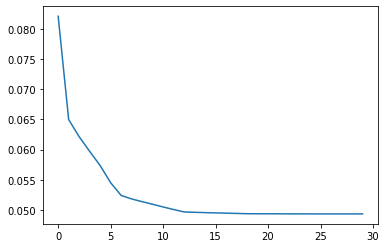

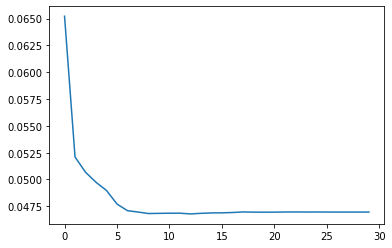

In [13]:
print(best_loss)
plt.plot(loss_history)
plt.show()
plt.plot(val_loss_history)
plt.show()

#### Train Set

<AxesSubplot:>

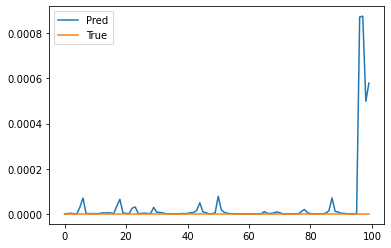

In [14]:
window = [37900, 38000]
pd.DataFrame({'Pred':best_train_pred[window[0]:window[1]], 'True':train_y_ordered[window[0]:window[1]]}).plot()

True pos:  420803
False pos:  386644
True neg:  22127594
False neg:  200015
Prec:  0.52115247192695
Recall:  0.6778202307278461
F1:  0.5892505942524672
AUC:  0.9812097468458476


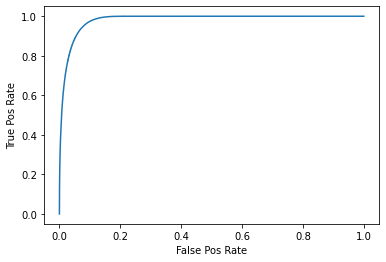

In [15]:
trn_tp = ((train_y_ordered>0.5)*(best_train_pred>binary_cutoff)).sum()
trn_fp = ((train_y_ordered<0.5)*(best_train_pred>binary_cutoff)).sum()
trn_tn = ((train_y_ordered<0.5)*(best_train_pred<binary_cutoff)).sum()
trn_fn = ((train_y_ordered>0.5)*(best_train_pred<binary_cutoff)).sum()

print('True pos: ',trn_tp)
print('False pos: ',trn_fp)
print('True neg: ', trn_tn)
print('False neg: ', trn_fn)

# Prec, recall, f1
trn_prec = trn_tp / (trn_tp + trn_fp)
trn_recall = trn_tp / (trn_tp + trn_fn)
print('Prec: ', trn_prec)
print('Recall: ', trn_recall)
print('F1: ', 2*(trn_prec*trn_recall)/(trn_prec + trn_recall))


# ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(train_y_ordered, best_train_pred, pos_label=1)
print('AUC: ', sklearn.metrics.auc(fpr, tpr))

plt.plot(fpr, tpr)
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate')
plt.show()

#### Validation

<AxesSubplot:>

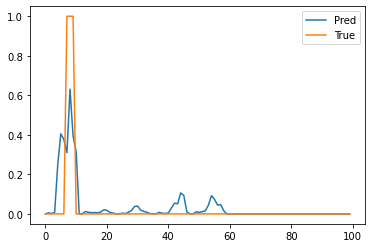

In [16]:
window = [30900, 31000]
pd.DataFrame({'Pred':best_val_pred[window[0]:window[1]], 'True':val_y_ordered[window[0]:window[1]]}).plot()

In [17]:
binary_cutoff=0.25

True pos:  39152
False pos:  55041
True neg:  3326841
False neg:  27670
Prec:  0.41565721444268683
Recall:  0.585914818472958
F1:  0.4863149396019005
F1:  0.4863149396019005
AUC:  0.9738687634709614


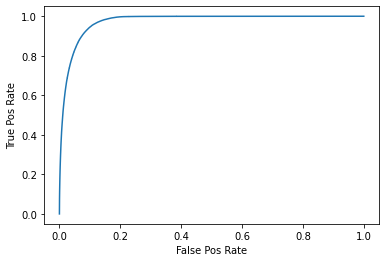

In [18]:
val_tp = ((val_y_ordered>0.5)*(best_val_pred>binary_cutoff)).sum()
val_fp = ((val_y_ordered<0.5)*(best_val_pred>binary_cutoff)).sum()
val_tn = ((val_y_ordered<0.5)*(best_val_pred<binary_cutoff)).sum()
val_fn = ((val_y_ordered>0.5)*(best_val_pred<binary_cutoff)).sum()

print('True pos: ',val_tp)
print('False pos: ',val_fp)
print('True neg: ', val_tn)
print('False neg: ', val_fn)

# Prec, recall, f1
val_prec = val_tp / (val_tp + val_fp)
val_recall = val_tp / (val_tp + val_fn)
print('Prec: ', val_prec)
print('Recall: ', val_recall)
print('F1: ', 2*(val_prec*val_recall)/(val_prec + val_recall))
print('F1: ', sklearn.metrics.f1_score(val_y_ordered, best_val_pred>binary_cutoff))


# ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(val_y_ordered, best_val_pred, pos_label=1)

print('AUC: ', sklearn.metrics.auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate')
plt.show()

In [19]:
%%bash 
sudo shutdown -h now